ABC
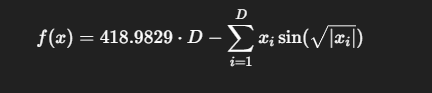

Best solution found:
x* = 420.968746 420.968746 420.968746 420.968746 420.968747 420.968746 420.968748 420.968747 420.968746 420.968748
f(x*) = 0.00012727566172543447


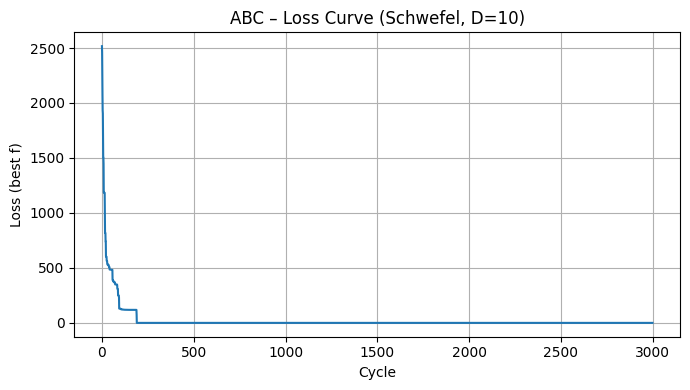

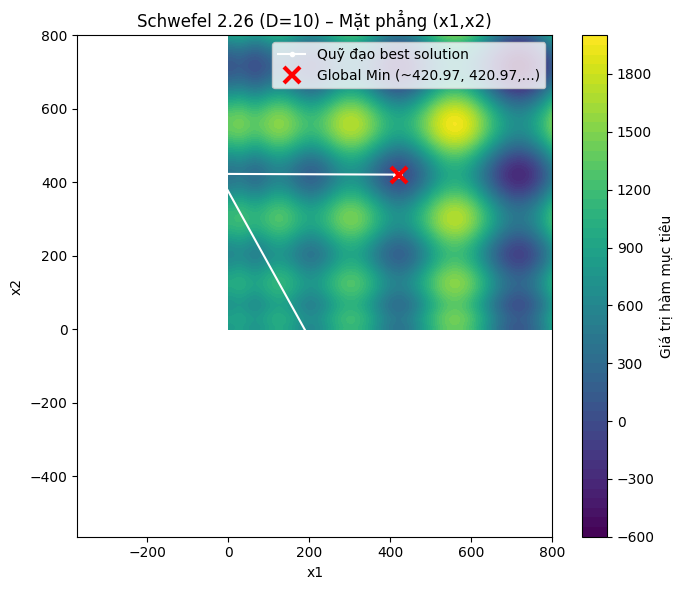

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# CẤU HÌNH CHÍNH
# ==========================

D = 10               # Số chiều nghiệm (tùy bạn: 2, 4, 10, 30,...)
FOOD_NUMBER = 100    # Số nguồn thức ăn (ong thợ)
LIMIT = 70           # Ngưỡng trial cho ong do thám
MAXCYCLE = 3000      # Số vòng lặp tối đa

LOWER = -500.0       # Giới hạn dưới Schwefel
UPPER = 500.0        # Giới hạn trên Schwefel

SCH_BEST = 420.9687  # Vị trí x* (xấp xỉ) cho từng chiều (global min)


# ==========================
# CẤU TRÚC NGUỒN THỨC ĂN
# ==========================

class FoodSource:
    def __init__(self):
        self.x = [0.0] * D
        self.f = 0.0
        self.fitness = 0.0
        self.trial = 0


foods = [FoodSource() for _ in range(FOOD_NUMBER)]
bestSolution = FoodSource()

loss_history = []       # Lưu best f theo từng cycle
best_positions = []     # Lưu best x theo từng cycle (để vẽ quỹ đạo nếu D >= 2)


# ==========================
# HÀM MỤC TIÊU: SCHWEFEL 2.26 N CHIỀU
# f(x) = 418.9829 * D - sum(x_i * sin(sqrt(|x_i|)))
# Global min = 0 tại x_i ≈ 420.9687
# ==========================

def schwefel_nd(x):
    D_local = len(x)
    s = 0.0
    for xi in x:
        s += xi * math.sin(math.sqrt(abs(xi)))
    return 418.9829 * D_local - s


def objectiveFunction(x):
    return schwefel_nd(x)


# ==========================
# FITNESS
# ==========================

def calculateFitness(f):
    # f càng nhỏ càng tốt → fitness càng lớn càng tốt
    if f >= 0:
        return 1.0 / (1.0 + f)
    return 1.0 + abs(f)


def clone_food(src: FoodSource) -> FoodSource:
    dst = FoodSource()
    dst.x = src.x[:]
    dst.f = src.f
    dst.fitness = src.fitness
    dst.trial = src.trial
    return dst


# ==========================
# KHỞI TẠO
# ==========================

def initialize():
    global bestSolution

    bestSolution.fitness = -1e100

    for i in range(FOOD_NUMBER):
        for j in range(D):
            foods[i].x[j] = LOWER + random.random() * (UPPER - LOWER)

        foods[i].f = objectiveFunction(foods[i].x)
        foods[i].fitness = calculateFitness(foods[i].f)
        foods[i].trial = 0

        if foods[i].fitness > bestSolution.fitness:
            bestSolution = clone_food(foods[i])


# ==========================
# PHA ONG THỢ
# ==========================

def employedBeePhase():
    for i in range(FOOD_NUMBER):
        newFood = clone_food(foods[i])
        j = random.randrange(D)

        # chọn k != i
        while True:
            k = random.randrange(FOOD_NUMBER)
            if k != i:
                break

        phi = random.random() * 2 - 1  # [-1, 1]

        newFood.x[j] = foods[i].x[j] + phi * (foods[i].x[j] - foods[k].x[j])
        newFood.x[j] = max(LOWER, min(UPPER, newFood.x[j]))

        newFood.f = objectiveFunction(newFood.x)
        newFood.fitness = calculateFitness(newFood.f)

        if newFood.fitness > foods[i].fitness:
            foods[i] = newFood
            foods[i].trial = 0
        else:
            foods[i].trial += 1


# ==========================
# PHA ONG QUAN SÁT
# ==========================

def onlookerBeePhase():
    sumFit = sum(f.fitness for f in foods)
    t = 0

    while t < FOOD_NUMBER:
        # Roulette wheel chọn nguồn
        r = random.random() * sumFit
        accum = 0.0
        idx = 0
        for i in range(FOOD_NUMBER):
            accum += foods[i].fitness
            if accum >= r:
                idx = i
                break

        i = idx
        newFood = clone_food(foods[i])
        j = random.randrange(D)

        while True:
            k = random.randrange(FOOD_NUMBER)
            if k != i:
                break

        phi = random.random() * 2 - 1

        newFood.x[j] = foods[i].x[j] + phi * (foods[i].x[j] - foods[k].x[j])
        newFood.x[j] = max(LOWER, min(UPPER, newFood.x[j]))

        newFood.f = objectiveFunction(newFood.x)
        newFood.fitness = calculateFitness(newFood.f)

        if newFood.fitness > foods[i].fitness:
            foods[i] = newFood
            foods[i].trial = 0
        else:
            foods[i].trial += 1

        t += 1


# ==========================
# PHA ONG DO THÁM
# ==========================

def scoutBeePhase():
    for i in range(FOOD_NUMBER):
        if foods[i].trial > LIMIT:
            for j in range(D):
                foods[i].x[j] = LOWER + random.random() * (UPPER - LOWER)

            foods[i].f = objectiveFunction(foods[i].x)
            foods[i].fitness = calculateFitness(foods[i].f)
            foods[i].trial = 0


def memorizeBest():
    global bestSolution
    for i in range(FOOD_NUMBER):
        if foods[i].fitness > bestSolution.fitness:
            bestSolution = clone_food(foods[i])


# ==========================
# VẼ HÀM 2D + QUỸ ĐẠO (nếu D >= 2)
# ==========================

def plot_landscape_and_trajectory():
    if D < 2:
        print("D < 2 nên không vẽ được contour 2D.")
        return

    # Vẽ trên mặt phẳng (x1, x2)
    BOUNDS = [0.0, 800.0]   # tập trung quanh vùng có nghiệm tốt (~420)
    RESOLUTION = 200

    x_grid = np.linspace(BOUNDS[0], BOUNDS[1], RESOLUTION)
    y_grid = np.linspace(BOUNDS[0], BOUNDS[1], RESOLUTION)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = np.zeros_like(X)
    for i in range(RESOLUTION):
        for j in range(RESOLUTION):
            point = [0.0] * D
            point[0] = X[i, j]
            point[1] = Y[i, j]
            # các chiều còn lại cố định tại SCH_BEST
            for d in range(2, D):
                point[d] = SCH_BEST
            Z[i, j] = objectiveFunction(point)

    bp = np.array(best_positions)  # (T, D)

    fig, ax = plt.subplots(figsize=(7, 6))

    contour = ax.contourf(X, Y, Z, levels=50)
    plt.colorbar(contour, ax=ax, label='Giá trị hàm mục tiêu')

    # Quỹ đạo nghiệm tốt nhất chiếu lên (x1, x2)
    ax.plot(bp[:, 0], bp[:, 1], 'w.-', label='Quỹ đạo best solution')

    # Đánh dấu global min ~ (420.97, 420.97)
    ax.plot(SCH_BEST, SCH_BEST, 'rx', markersize=12, markeredgewidth=3,
            label='Global Min (~420.97, 420.97,...)')

    ax.set_title(f'Schwefel 2.26 (D={D}) – Mặt phẳng (x1,x2)')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

    plt.tight_layout()
    plt.show()


def plot_loss_curve():
    plt.figure(figsize=(7, 4))
    plt.plot(loss_history)
    plt.xlabel('Cycle')
    plt.ylabel('Loss (best f)')
    plt.title(f'ABC – Loss Curve (Schwefel, D={D})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ==========================
# MAIN
# ==========================

def main():
    random.seed()
    initialize()

    for cycle in range(MAXCYCLE):
        employedBeePhase()
        onlookerBeePhase()
        scoutBeePhase()
        memorizeBest()

        loss_history.append(bestSolution.f)
        best_positions.append(bestSolution.x[:])

    print("Best solution found:")
    print("x* =", " ".join(f"{v:.6f}" for v in bestSolution.x))
    print("f(x*) =", bestSolution.f)

    plot_loss_curve()
    plot_landscape_and_trajectory()


if __name__ == "__main__":
    main()


GABC

Best solution found (GABC):
x* = 420.968745 420.968746 420.968747 420.968746 420.968746 420.968747 420.968746 420.968747 420.968746 420.968747
f(x*) = 0.00012727566172543447


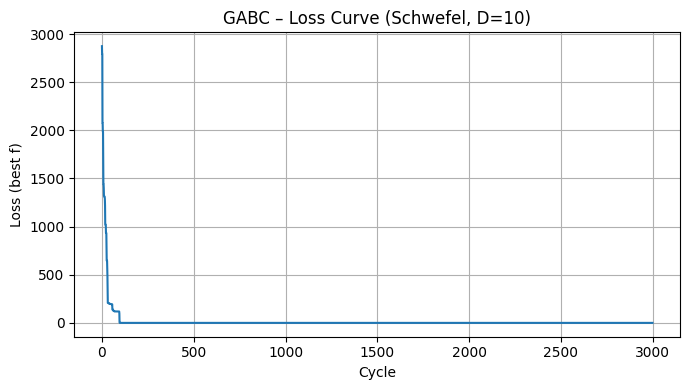

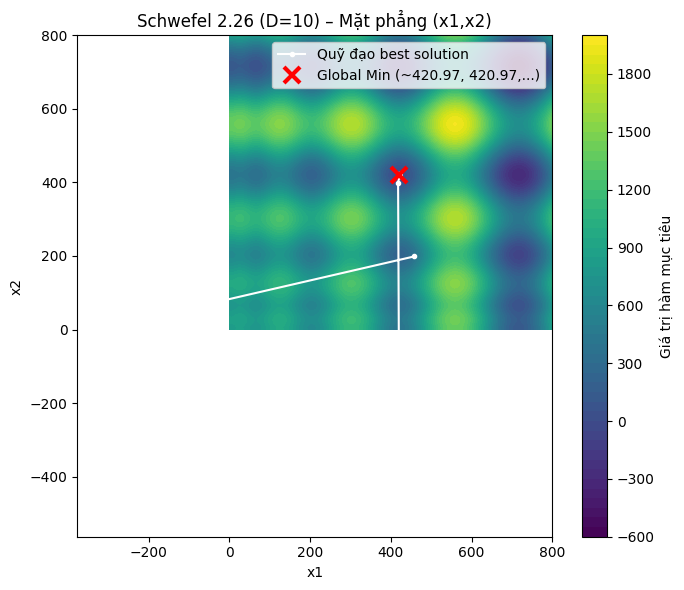

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# CẤU HÌNH CHÍNH
# ==========================

D = 10               # Số chiều nghiệm (tùy bạn: 2, 4, 10, 30,...)
FOOD_NUMBER = 100    # Số nguồn thức ăn (ong thợ)
LIMIT = 70           # Ngưỡng trial cho ong do thám
MAXCYCLE = 3000      # Số vòng lặp tối đa

LOWER = -500.0       # Giới hạn dưới Schwefel
UPPER = 500.0        # Giới hạn trên Schwefel

SCH_BEST = 420.9687  # Vị trí x* (xấp xỉ) cho từng chiều (global min)

# GABC parameters
C = 1.5              # Hằng số điều khiển mức độ "hút về gbest" (psi ∈ [0, C])

# ==========================
# CẤU TRÚC NGUỒN THỨC ĂN
# ==========================

class FoodSource:
    def __init__(self):
        self.x = [0.0] * D
        self.f = 0.0
        self.fitness = 0.0
        self.trial = 0


foods = [FoodSource() for _ in range(FOOD_NUMBER)]
bestSolution = FoodSource()

loss_history = []       # Lưu best f theo từng cycle
best_positions = []     # Lưu best x theo từng cycle (để vẽ quỹ đạo nếu D >= 2)


# ==========================
# HÀM MỤC TIÊU: SCHWEFEL 2.26 N CHIỀU
# f(x) = 418.9829 * D - sum(x_i * sin(sqrt(|x_i|)))
# Global min = 0 tại x_i ≈ 420.9687
# ==========================

def schwefel_nd(x):
    D_local = len(x)
    s = 0.0
    for xi in x:
        s += xi * math.sin(math.sqrt(abs(xi)))
    return 418.9829 * D_local - s


def objectiveFunction(x):
    return schwefel_nd(x)


# ==========================
# FITNESS
# ==========================

def calculateFitness(f):
    # f càng nhỏ càng tốt → fitness càng lớn càng tốt
    if f >= 0:
        return 1.0 / (1.0 + f)
    return 1.0 + abs(f)


def clone_food(src: FoodSource) -> FoodSource:
    dst = FoodSource()
    dst.x = src.x[:]
    dst.f = src.f
    dst.fitness = src.fitness
    dst.trial = src.trial
    return dst


# ==========================
# KHỞI TẠO
# ==========================

def initialize():
    global bestSolution

    # Khởi tạo bestSolution fitness thấp để dễ cập nhật
    bestSolution.fitness = -1e100
    bestSolution.f = float('inf')

    for i in range(FOOD_NUMBER):
        for j in range(D):
            foods[i].x[j] = LOWER + random.random() * (UPPER - LOWER)

        foods[i].f = objectiveFunction(foods[i].x)
        foods[i].fitness = calculateFitness(foods[i].f)
        foods[i].trial = 0

        if foods[i].fitness > bestSolution.fitness:
            bestSolution = clone_food(foods[i])


# ==========================
# PHA ONG THỢ (GABC)
# ==========================

def employedBeePhase():
    for i in range(FOOD_NUMBER):
        newFood = clone_food(foods[i])
        j = random.randrange(D)

        # chọn k != i
        while True:
            k = random.randrange(FOOD_NUMBER)
            if k != i:
                break

        phi = random.random() * 2 - 1  # [-1, 1]

        # psi ∈ [0, C]
        psi = random.random() * C

        # GABC update: v = x_i + phi*(x_i - x_k) + psi*(gbest - x_i)
        newFood.x[j] = (foods[i].x[j]
                        + phi * (foods[i].x[j] - foods[k].x[j])
                        + psi * (bestSolution.x[j] - foods[i].x[j]))

        # giữ trong biên
        newFood.x[j] = max(LOWER, min(UPPER, newFood.x[j]))

        newFood.f = objectiveFunction(newFood.x)
        newFood.fitness = calculateFitness(newFood.f)

        if newFood.fitness > foods[i].fitness:
            foods[i] = newFood
            foods[i].trial = 0
        else:
            foods[i].trial += 1


# ==========================
# PHA ONG QUAN SÁT (GABC)
# ==========================

def onlookerBeePhase():
    sumFit = sum(f.fitness for f in foods)
    if sumFit == 0.0:
        return

    t = 0
    while t < FOOD_NUMBER:
        # Roulette wheel chọn nguồn
        r = random.random() * sumFit
        accum = 0.0
        idx = 0
        for i in range(FOOD_NUMBER):
            accum += foods[i].fitness
            if accum >= r:
                idx = i
                break

        i = idx
        newFood = clone_food(foods[i])
        j = random.randrange(D)

        # chọn k != i
        while True:
            k = random.randrange(FOOD_NUMBER)
            if k != i:
                break

        phi = random.random() * 2 - 1  # [-1, 1]
        psi = random.random() * C     # psi ∈ [0, C]

        newFood.x[j] = (foods[i].x[j]
                        + phi * (foods[i].x[j] - foods[k].x[j])
                        + psi * (bestSolution.x[j] - foods[i].x[j]))

        newFood.x[j] = max(LOWER, min(UPPER, newFood.x[j]))

        newFood.f = objectiveFunction(newFood.x)
        newFood.fitness = calculateFitness(newFood.f)

        if newFood.fitness > foods[i].fitness:
            foods[i] = newFood
            foods[i].trial = 0
        else:
            foods[i].trial += 1

        t += 1


# ==========================
# PHA ONG DO THÁM
# ==========================

def scoutBeePhase():
    for i in range(FOOD_NUMBER):
        if foods[i].trial > LIMIT:
            for j in range(D):
                foods[i].x[j] = LOWER + random.random() * (UPPER - LOWER)

            foods[i].f = objectiveFunction(foods[i].x)
            foods[i].fitness = calculateFitness(foods[i].f)
            foods[i].trial = 0


def memorizeBest():
    global bestSolution
    for i in range(FOOD_NUMBER):
        if foods[i].fitness > bestSolution.fitness:
            bestSolution = clone_food(foods[i])


# ==========================
# VẼ HÀM 2D + QUỸ ĐẠO (nếu D >= 2)
# ==========================

def plot_landscape_and_trajectory():
    if D < 2:
        print("D < 2 nên không vẽ được contour 2D.")
        return

    # Vẽ trên mặt phẳng (x1, x2)
    BOUNDS = [0.0, 800.0]   # tập trung quanh vùng có nghiệm tốt (~420)
    RESOLUTION = 200

    x_grid = np.linspace(BOUNDS[0], BOUNDS[1], RESOLUTION)
    y_grid = np.linspace(BOUNDS[0], BOUNDS[1], RESOLUTION)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = np.zeros_like(X)
    for i in range(RESOLUTION):
        for j in range(RESOLUTION):
            point = [0.0] * D
            point[0] = X[i, j]
            point[1] = Y[i, j]
            # các chiều còn lại cố định tại SCH_BEST
            for d in range(2, D):
                point[d] = SCH_BEST
            Z[i, j] = objectiveFunction(point)

    bp = np.array(best_positions)  # (T, D)

    fig, ax = plt.subplots(figsize=(7, 6))

    contour = ax.contourf(X, Y, Z, levels=50)
    plt.colorbar(contour, ax=ax, label='Giá trị hàm mục tiêu')

    # Quỹ đạo nghiệm tốt nhất chiếu lên (x1, x2)
    ax.plot(bp[:, 0], bp[:, 1], 'w.-', label='Quỹ đạo best solution')

    # Đánh dấu global min ~ (420.97, 420.97)
    ax.plot(SCH_BEST, SCH_BEST, 'rx', markersize=12, markeredgewidth=3,
            label='Global Min (~420.97, 420.97,...)')

    ax.set_title(f'Schwefel 2.26 (D={D}) – Mặt phẳng (x1,x2)')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

    plt.tight_layout()
    plt.show()


def plot_loss_curve():
    plt.figure(figsize=(7, 4))
    plt.plot(loss_history)
    plt.xlabel('Cycle')
    plt.ylabel('Loss (best f)')
    plt.title(f'GABC – Loss Curve (Schwefel, D={D})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ==========================
# MAIN
# ==========================

def main():
    random.seed()
    initialize()

    for cycle in range(MAXCYCLE):
        employedBeePhase()
        onlookerBeePhase()
        scoutBeePhase()
        memorizeBest()

        loss_history.append(bestSolution.f)
        best_positions.append(bestSolution.x[:])

    print("Best solution found (GABC):")
    print("x* =", " ".join(f"{v:.6f}" for v in bestSolution.x))
    print("f(x*) =", bestSolution.f)

    plot_loss_curve()
    plot_landscape_and_trajectory()


if __name__ == "__main__":
    main()


QABC

Best solution found:
x* = [420.9687470412173, 420.9687465864474, 420.96874779274094, 420.9687453890972, 420.9687468643036, 420.9687464903434, 420.9687458298087, 420.9687473772398, 420.96874639510304, 420.96874645105044]
f(x*) = 0.00012727566172543447


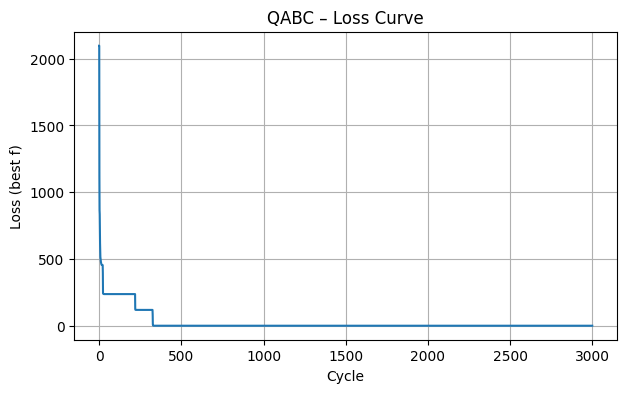

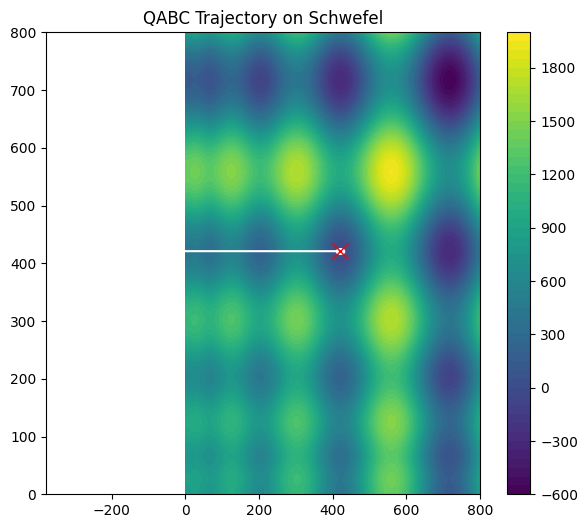

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# CẤU HÌNH CHÍNH
# ==========================

D = 10
FOOD_NUMBER = 100
LIMIT = 70
MAXCYCLE = 3000

LOWER = -500.0
UPPER = 500.0
SCH_BEST = 420.9687

Q_LAMBDA = 0.75       # hệ số lượng tử

class FoodSource:
    def __init__(self):
        self.x = [0.0] * D
        self.f = 0.0
        self.fitness = 0.0
        self.trial = 0

foods = [FoodSource() for _ in range(FOOD_NUMBER)]
bestSolution = FoodSource()

loss_history = []
best_positions = []

# ==============================================
# HÀM SCHWEFEL 2.26
# ==============================================

def schwefel_nd(x):
    s = 0.0
    for xi in x:
        s += xi * math.sin(math.sqrt(abs(xi)))
    return 418.9829 * len(x) - s

def objectiveFunction(x):
    return schwefel_nd(x)

def calculateFitness(f):
    return 1 / (1 + f) if f >= 0 else 1 + abs(f)

def clone_food(src):
    dst = FoodSource()
    dst.x = src.x[:]
    dst.f = src.f
    dst.fitness = src.fitness
    dst.trial = src.trial
    return dst

# ==============================================
# KHỞI TẠO
# ==============================================

def initialize():
    global bestSolution
    bestSolution.fitness = -1e100

    for i in range(FOOD_NUMBER):
        for j in range(D):
            foods[i].x[j] = LOWER + random.random() * (UPPER - LOWER)

        foods[i].f = objectiveFunction(foods[i].x)
        foods[i].fitness = calculateFitness(foods[i].f)

        if foods[i].fitness > bestSolution.fitness:
            bestSolution = clone_food(foods[i])

# ==============================================
# HÀM CẬP NHẬT LƯỢNG TỬ (Quantum Update)
# ==============================================

def quantum_update(xi, gbest):
    """Tạo nghiệm mới theo chuyển động lượng tử"""
    new_x = xi[:]

    for j in range(D):
        u = random.random()
        sign = 1 if random.random() < 0.5 else -1

        r = Q_LAMBDA * abs(xi[j] - gbest[j]) * math.log(1.0 / u)
        new_x[j] = 0.5 * (xi[j] + gbest[j]) + sign * r

        # ép biên
        new_x[j] = max(LOWER, min(UPPER, new_x[j]))

    return new_x

# ==============================================
# PHA ONG THỢ (QABC)
# ==============================================

def employedBeePhase():
    for i in range(FOOD_NUMBER):
        new_x = quantum_update(foods[i].x, bestSolution.x)
        new_f = objectiveFunction(new_x)
        new_fit = calculateFitness(new_f)

        if new_fit > foods[i].fitness:
            foods[i].x = new_x
            foods[i].f = new_f
            foods[i].fitness = new_fit
            foods[i].trial = 0
        else:
            foods[i].trial += 1

# ==============================================
# PHA ONG QUAN SÁT (QABC)
# ==============================================

def onlookerBeePhase():
    sumFit = sum(f.fitness for f in foods)
    t = 0

    while t < FOOD_NUMBER:
        r = random.random() * sumFit
        accum = 0
        idx = 0
        for i in range(FOOD_NUMBER):
            accum += foods[i].fitness
            if accum >= r:
                idx = i
                break

        new_x = quantum_update(foods[idx].x, bestSolution.x)
        new_f = objectiveFunction(new_x)
        new_fit = calculateFitness(new_f)

        if new_fit > foods[idx].fitness:
            foods[idx].x = new_x
            foods[idx].f = new_f
            foods[idx].fitness = new_fit
            foods[idx].trial = 0
        else:
            foods[idx].trial += 1

        t += 1

# ==============================================
# ONG DO THÁM
# ==============================================

def scoutBeePhase():
    for i in range(FOOD_NUMBER):
        if foods[i].trial > LIMIT:
            for j in range(D):
                foods[i].x[j] = LOWER + random.random() * (UPPER - LOWER)
            foods[i].f = objectiveFunction(foods[i].x)
            foods[i].fitness = calculateFitness(foods[i].f)
            foods[i].trial = 0

def memorizeBest():
    global bestSolution
    for fs in foods:
        if fs.fitness > bestSolution.fitness:
            bestSolution = clone_food(fs)

# ==============================================
# VẼ ĐỒ THỊ
# ==============================================

def plot_loss_curve():
    plt.figure(figsize=(7, 4))
    plt.plot(loss_history)
    plt.xlabel('Cycle')
    plt.ylabel('Loss (best f)')
    plt.title('QABC – Loss Curve')
    plt.grid(True)
    plt.show()

def plot_landscape_and_trajectory():
    if D < 2:
        return

    BOUNDS = [0, 800]
    RES = 200
    xg = np.linspace(BOUNDS[0], BOUNDS[1], RES)
    yg = np.linspace(BOUNDS[0], BOUNDS[1], RES)
    X, Y = np.meshgrid(xg, yg)
    Z = np.zeros_like(X)

    for i in range(RES):
        for j in range(RES):
            p = [SCH_BEST] * D
            p[0] = X[i, j]
            p[1] = Y[i, j]
            Z[i, j] = objectiveFunction(p)

    fig, ax = plt.subplots(figsize=(7, 6))
    contour = ax.contourf(X, Y, Z, 50)
    plt.colorbar(contour)

    bp = np.array(best_positions)
    ax.plot(bp[:, 0], bp[:, 1], 'w.-', label="Trajectory")

    ax.plot(SCH_BEST, SCH_BEST, 'rx', markersize=12)
    ax.set_title("QABC Trajectory on Schwefel")
    plt.show()

# ==============================================
# MAIN
# ==============================================

def main():
    random.seed()
    initialize()

    for cycle in range(MAXCYCLE):
        employedBeePhase()
        onlookerBeePhase()
        scoutBeePhase()
        memorizeBest()

        loss_history.append(bestSolution.f)
        best_positions.append(bestSolution.x[:])

    print("Best solution found:")
    print("x* =", bestSolution.x)
    print("f(x*) =", bestSolution.f)

    plot_loss_curve()
    plot_landscape_and_trajectory()

if __name__ == "__main__":
    main()


Biểu đồ hiệu suất

--- Đang chạy Classic ABC (15 runs) ---
   -> Time: 56.33s | Final Mean Error: 1.2728e-04
--- Đang chạy GABC (15 runs) ---
   -> Time: 56.52s | Final Mean Error: 1.2728e-04
--- Đang chạy qABC (15 runs) ---
   -> Time: 102.01s | Final Mean Error: 1.2728e-04


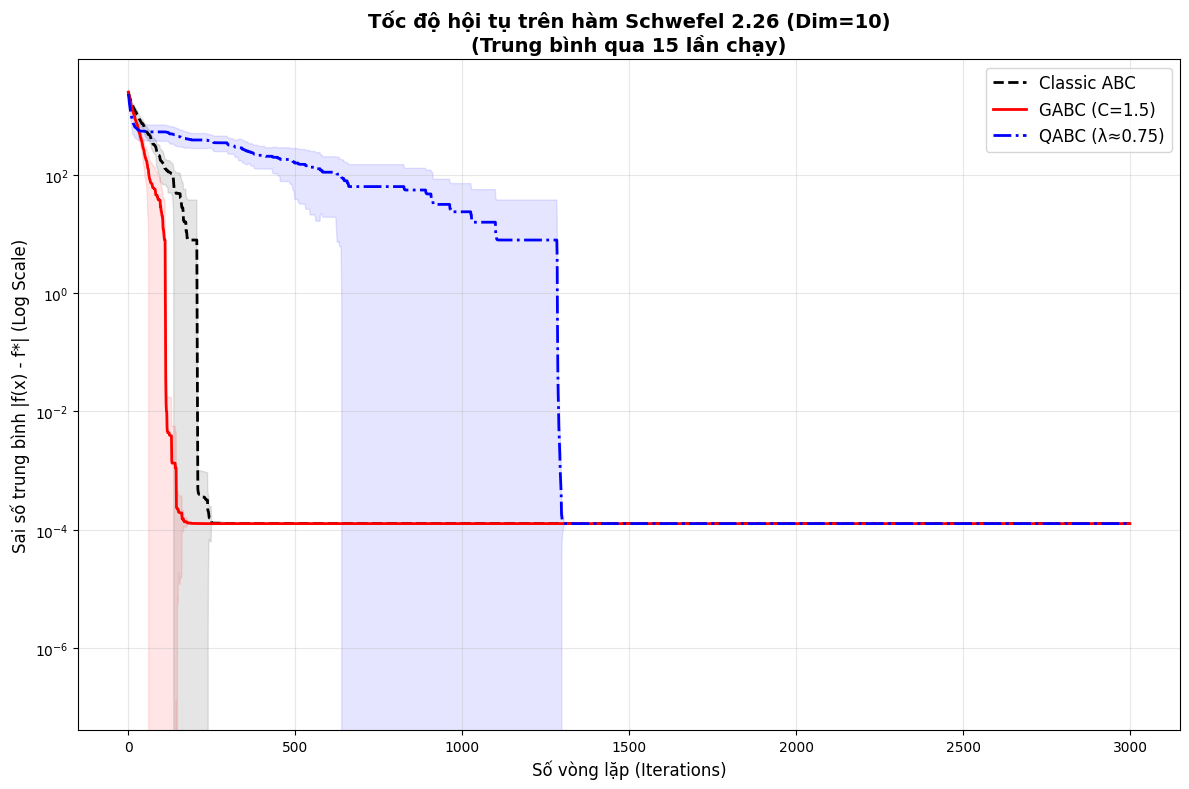

In [ ]:
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt

# =========================================
# 1. HÀM MỤC TIÊU: SCHWEFEL 2.26 N CHIỀU
# f(x) = 418.9829 * D - sum(x_i * sin(sqrt(|x_i|)))
# Global min = 0 tại x_i ≈ 420.9687
# =========================================

def schwefel_nd(x):
    D_local = len(x)
    s = 0.0
    for xi in x:
        s += xi * math.sin(math.sqrt(abs(xi)))
    return 418.9829 * D_local - s


# =========================================
# 2. HÀM FITNESS CHUNG
# =========================================

def calculate_fitness(f):
    # f càng nhỏ càng tốt → fitness càng lớn càng tốt
    if f >= 0:
        return 1.0 / (1.0 + f)
    return 1.0 + abs(f)


# =========================================
# 3. LỚP FOOD SOURCE DÙNG CHUNG
# =========================================

class FoodSource:
    def __init__(self, dim):
        self.x = [0.0] * dim
        self.f = float('inf')
        self.fitness = -1e100
        self.trial = 0

    def clone(self):
        fs = FoodSource(len(self.x))
        fs.x = self.x[:]
        fs.f = self.f
        fs.fitness = self.fitness
        fs.trial = self.trial
        return fs


# =========================================
# 4. ABC CỔ ĐIỂN
# =========================================

class ClassicABC:
    def __init__(self, func, dim, bounds, n_bees, max_iter, limit, optimal_val):
        self.func = func
        self.dim = dim
        self.lb, self.ub = bounds
        self.sn = n_bees           # số nguồn thức ăn = số ong thợ = số ong quan sát
        self.max_iter = max_iter
        self.limit = limit
        self.optimal_val = optimal_val

        self.foods = [FoodSource(dim) for _ in range(self.sn)]
        self.best = FoodSource(dim)

        self._initialize()

    def _initialize(self):
        self.best.fitness = -1e100
        self.best.f = float('inf')

        for i in range(self.sn):
            for j in range(self.dim):
                self.foods[i].x[j] = self.lb + random.random() * (self.ub - self.lb)

            self.foods[i].f = self.func(self.foods[i].x)
            self.foods[i].fitness = calculate_fitness(self.foods[i].f)
            self.foods[i].trial = 0

            if self.foods[i].fitness > self.best.fitness:
                self.best = self.foods[i].clone()

    # Pha ong thợ
    def _employed_phase(self):
        for i in range(self.sn):
            newFood = self.foods[i].clone()
            j = random.randrange(self.dim)

            # chọn k != i
            while True:
                k = random.randrange(self.sn)
                if k != i:
                    break

            phi = random.random() * 2 - 1  # [-1, 1]

            newFood.x[j] = (self.foods[i].x[j] +
                             phi * (self.foods[i].x[j] - self.foods[k].x[j]))
            # ép biên
            newFood.x[j] = max(self.lb, min(self.ub, newFood.x[j]))

            newFood.f = self.func(newFood.x)
            newFood.fitness = calculate_fitness(newFood.f)

            if newFood.fitness > self.foods[i].fitness:
                self.foods[i] = newFood
                self.foods[i].trial = 0
            else:
                self.foods[i].trial += 1

    # Pha ong quan sát
    def _onlooker_phase(self):
        sumFit = sum(fs.fitness for fs in self.foods)
        if sumFit == 0:
            return

        t = 0
        while t < self.sn:
            r = random.random() * sumFit
            accum = 0.0
            idx = 0
            for i in range(self.sn):
                accum += self.foods[i].fitness
                if accum >= r:
                    idx = i
                    break

            i = idx
            newFood = self.foods[i].clone()
            j = random.randrange(self.dim)

            while True:
                k = random.randrange(self.sn)
                if k != i:
                    break

            phi = random.random() * 2 - 1

            newFood.x[j] = (self.foods[i].x[j] +
                             phi * (self.foods[i].x[j] - self.foods[k].x[j]))
            newFood.x[j] = max(self.lb, min(self.ub, newFood.x[j]))

            newFood.f = self.func(newFood.x)
            newFood.fitness = calculate_fitness(newFood.f)

            if newFood.fitness > self.foods[i].fitness:
                self.foods[i] = newFood
                self.foods[i].trial = 0
            else:
                self.foods[i].trial += 1

            t += 1

    # Pha ong do thám
    def _scout_phase(self):
        for i in range(self.sn):
            if self.foods[i].trial > self.limit:
                for j in range(self.dim):
                    self.foods[i].x[j] = self.lb + random.random() * (self.ub - self.lb)
                self.foods[i].f = self.func(self.foods[i].x)
                self.foods[i].fitness = calculate_fitness(self.foods[i].f)
                self.foods[i].trial = 0

    # Cập nhật best
    def _memorize_best(self):
        for i in range(self.sn):
            if self.foods[i].fitness > self.best.fitness:
                self.best = self.foods[i].clone()

    def run(self):
        history = []
        for it in range(self.max_iter):
            self._employed_phase()
            self._onlooker_phase()
            self._scout_phase()
            self._memorize_best()

            err = abs(self.best.f - self.optimal_val)
            history.append(err)

        return self.best.x, self.best.f, history


# =========================================
# 5. GABC – Gbest-guided ABC
# =========================================

class GABC(ClassicABC):
    def __init__(self, func, dim, bounds, n_bees, max_iter, limit, optimal_val, C=1.5):
        self.C = C
        super().__init__(func, dim, bounds, n_bees, max_iter, limit, optimal_val)

    # GABC: pha ong thợ có term hướng về gbest
    def _employed_phase(self):
        for i in range(self.sn):
            newFood = self.foods[i].clone()
            j = random.randrange(self.dim)

            while True:
                k = random.randrange(self.sn)
                if k != i:
                    break

            phi = random.random() * 2 - 1
            psi = random.random() * self.C

            newFood.x[j] = (self.foods[i].x[j]
                            + phi * (self.foods[i].x[j] - self.foods[k].x[j])
                            + psi * (self.best.x[j] - self.foods[i].x[j]))
            newFood.x[j] = max(self.lb, min(self.ub, newFood.x[j]))

            newFood.f = self.func(newFood.x)
            newFood.fitness = calculate_fitness(newFood.f)

            if newFood.fitness > self.foods[i].fitness:
                self.foods[i] = newFood
                self.foods[i].trial = 0
            else:
                self.foods[i].trial += 1

    # GABC: pha ong quan sát cũng có term gbest
    def _onlooker_phase(self):
        sumFit = sum(fs.fitness for fs in self.foods)
        if sumFit == 0:
            return

        t = 0
        while t < self.sn:
            r = random.random() * sumFit
            accum = 0.0
            idx = 0
            for i in range(self.sn):
                accum += self.foods[i].fitness
                if accum >= r:
                    idx = i
                    break

            i = idx
            newFood = self.foods[i].clone()
            j = random.randrange(self.dim)

            while True:
                k = random.randrange(self.sn)
                if k != i:
                    break

            phi = random.random() * 2 - 1
            psi = random.random() * self.C

            newFood.x[j] = (self.foods[i].x[j]
                            + phi * (self.foods[i].x[j] - self.foods[k].x[j])
                            + psi * (self.best.x[j] - self.foods[i].x[j]))
            newFood.x[j] = max(self.lb, min(self.ub, newFood.x[j]))

            newFood.f = self.func(newFood.x)
            newFood.fitness = calculate_fitness(newFood.f)

            if newFood.fitness > self.foods[i].fitness:
                self.foods[i] = newFood
                self.foods[i].trial = 0
            else:
                self.foods[i].trial += 1

            t += 1


# =========================================
# 6. QABC – Quantum ABC
# =========================================

class qABC(ClassicABC):
    def __init__(self, func, dim, bounds, n_bees, max_iter, limit, optimal_val,
                 radius_ratio=0.75):
        # dùng radius_ratio làm hệ số lượng tử
        self.q_lambda = radius_ratio
        super().__init__(func, dim, bounds, n_bees, max_iter, limit, optimal_val)

    def _quantum_update(self, xi, gbest):
        new_x = xi[:]
        for j in range(self.dim):
            u = random.random()
            sign = 1 if random.random() < 0.5 else -1
            r = self.q_lambda * abs(xi[j] - gbest[j]) * math.log(1.0 / u)
            new_x[j] = 0.5 * (xi[j] + gbest[j]) + sign * r
            new_x[j] = max(self.lb, min(self.ub, new_x[j]))
        return new_x

    def _employed_phase(self):
        for i in range(self.sn):
            new_x = self._quantum_update(self.foods[i].x, self.best.x)
            new_f = self.func(new_x)
            new_fit = calculate_fitness(new_f)

            if new_fit > self.foods[i].fitness:
                self.foods[i].x = new_x
                self.foods[i].f = new_f
                self.foods[i].fitness = new_fit
                self.foods[i].trial = 0
            else:
                self.foods[i].trial += 1

    def _onlooker_phase(self):
        sumFit = sum(fs.fitness for fs in self.foods)
        if sumFit == 0:
            return

        t = 0
        while t < self.sn:
            r = random.random() * sumFit
            accum = 0.0
            idx = 0
            for i in range(self.sn):
                accum += self.foods[i].fitness
                if accum >= r:
                    idx = i
                    break

            new_x = self._quantum_update(self.foods[idx].x, self.best.x)
            new_f = self.func(new_x)
            new_fit = calculate_fitness(new_f)

            if new_fit > self.foods[idx].fitness:
                self.foods[idx].x = new_x
                self.foods[idx].f = new_f
                self.foods[idx].fitness = new_fit
                self.foods[idx].trial = 0
            else:
                self.foods[idx].trial += 1

            t += 1


# =========================================
# 7. KHUNG THỐNG KÊ MONTE CARLO & VẼ ĐỒ THỊ
# =========================================

# CẤU HÌNH THỰC NGHIỆM
CURRENT_FUNC = schwefel_nd
DIMENSION = 10
BOUNDS = (-500.0, 500.0)
TARGET = 0.0  # global min của Schwefel

PARAMS = {
    'func': CURRENT_FUNC,
    'dim': DIMENSION,
    'bounds': BOUNDS,
    'n_bees': 100,
    'max_iter': 3000,
    'limit': 70,
    'optimal_val': TARGET
}

NUM_RUNS = 15  # số lần chạy để lấy trung bình


def run_multiple_times(algorithm_class, kwargs, runs=10, alg_params=None, name="Algo"):
    if alg_params is None:
        alg_params = {}

    all_histories = []
    final_values = []
    print(f"--- Đang chạy {name} ({runs} runs) ---")

    t0 = time.time()
    for r in range(runs):
        algo = algorithm_class(**kwargs, **alg_params)
        _, final_val, hist = algo.run()
        all_histories.append(hist)
        final_values.append(final_val)

    all_histories = np.array(all_histories)
    avg_hist = np.mean(all_histories, axis=0)
    std_hist = np.std(all_histories, axis=0)
    avg_final = np.mean(final_values)

    print(f"   -> Time: {time.time()-t0:.2f}s | Final Mean Error: {avg_final:.4e}")
    return avg_hist, std_hist


def plot_shade(x, mean, std, color, label, style):
    plt.plot(x, mean, color=color, linestyle=style, linewidth=2, label=label)
    plt.fill_between(x, mean - std, mean + std, color=color, alpha=0.1)


def main():
    # 1. THỰC THI 3 THUẬT TOÁN
    abc_mean, abc_std = run_multiple_times(
        ClassicABC, PARAMS, runs=NUM_RUNS, name="Classic ABC"
    )

    gabc_mean, gabc_std = run_multiple_times(
        GABC, PARAMS, runs=NUM_RUNS, alg_params={'C': 1.5}, name="GABC"
    )

    qabc_mean, qabc_std = run_multiple_times(
        qABC, PARAMS, runs=NUM_RUNS, alg_params={'radius_ratio': 0.75}, name="qABC"
    )

    # 2. VẼ ĐỒ THỊ SO SÁNH
    plt.figure(figsize=(12, 8))
    x = range(PARAMS['max_iter'])

    plot_shade(x, abc_mean, abc_std, 'black', 'Classic ABC', '--')
    plot_shade(x, gabc_mean, gabc_std, 'red', 'GABC (C=1.5)', '-')
    plot_shade(x, qabc_mean, qabc_std, 'blue', 'QABC (λ≈0.75)', '-.')

    plt.yscale('log')
    plt.title(
        f'Tốc độ hội tụ trên hàm Schwefel 2.26 (Dim={DIMENSION})\n'
        f'(Trung bình qua {NUM_RUNS} lần chạy)',
        fontsize=14, fontweight='bold'
    )
    plt.xlabel('Số vòng lặp (Iterations)', fontsize=12)
    plt.ylabel('Sai số trung bình |f(x) - f*| (Log Scale)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
